In [165]:
import os
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray

from my_functions import *
from my_filters import *


In [166]:
# if pwd is SRC  change to root
print("Current working directory: ", os.getcwd())
if os.path.basename(os.getcwd()) == "SRC":
    os.chdir("..")
print("Current working directory: ", os.getcwd())
print(os.path.basename(os.getcwd()))

Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio
Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio
Stage_Signal_Physio


In [167]:
plt.close("all")  # close all figure windows
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['figure.figsize'] = [15, 5]  # Width x Height in inches
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['legend.fontsize'] = 12  # Adjust the size (in points) as needed


In [168]:
# Define the xdf file of interest
xdf_input_filename = "001_MolLud_20201112_1_c.xdf"
#xdf_input_filename="020_DesMar_20211129_1_c.xdf"

xdf_input_filepath = os.path.normpath("DAT/INPUT/"+xdf_input_filename)

In [169]:
# definition of the EEG channels' names
channels_dict = {"Channel_1": "C4",
                 "Channel_2": "FC2",
                 "Channel_3": "FC6",
                 "Channel_4": "CP2",
                 "Channel_5": "C3",
                 "Channel_6": "FC1",
                 "Channel_7": "FC5",
                 "Channel_8": "CP1"}

# EEG

## Import EEG signals and shape data

In [170]:
EEG_data = retrieve_stream_data_from_xdf(xdf_input_filepath=xdf_input_filepath, stream_type="EEG")

EEG_timestamps = EEG_data["data"]["timestamps"] - EEG_data["data"]["timestamps"][0]
EEG_srate = EEG_data["infos"]["sample_rate"]["effective"]
EEG_units = np.unique(EEG_data["infos"]["channels"]["units"])[0]

Accessing stream: 
Type: 'EEG' | Name: 'LSLOutletStreamName-EEG'


## Import event markers and format data

In [171]:
mouse_marker_times_labels = create_marker_times_labels_array2(xdf_input_filepath=xdf_input_filepath)
nearest_markers_array = nearest_timestamps_array_finder(signal_times_stamps=EEG_timestamps, markers=mouse_marker_times_labels)

# make times start in reference to the first EEG timestamp instead of unix epoch.
mouse_marker_times_labels[:, 0] -= EEG_data["data"]["timestamps"][0]

Accessing stream: 
Type: 'Markers' | Name: 'MouseToNIC'
MARKERS LEN: 12


In [172]:
channel_num=5
channel_index=channel_num-1
channel_num_name=f"Channel_{channel_num}"
channel_name=channels_dict[channel_num_name]

## Plot one Raw EEG signal

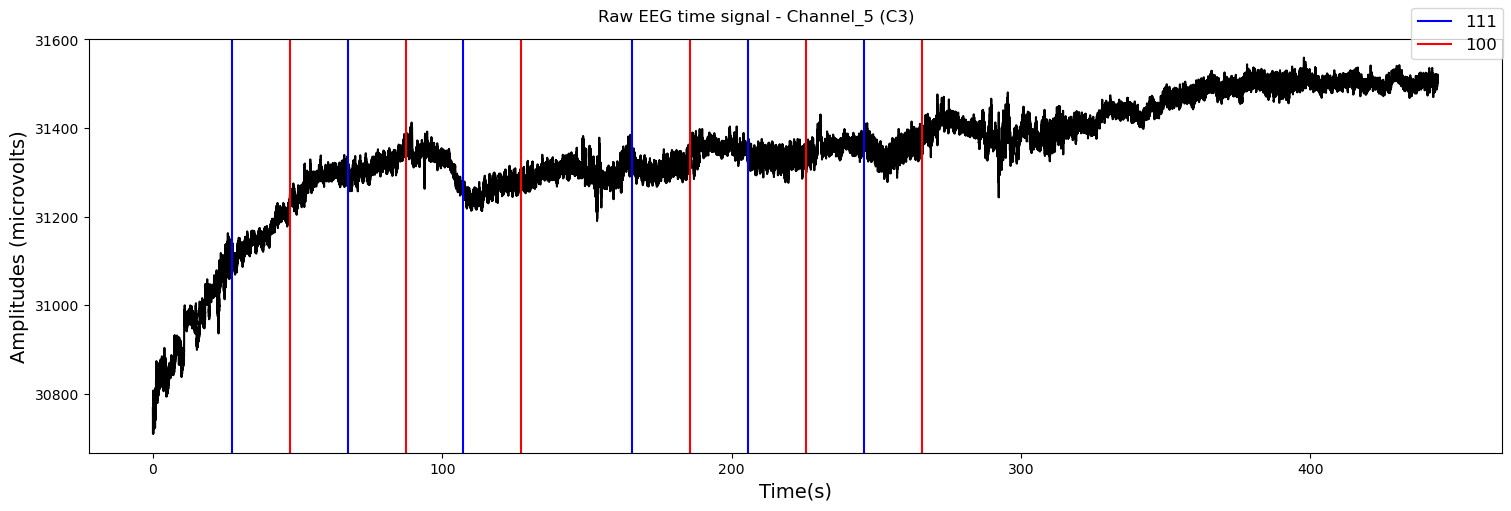

In [173]:
figure,axis=plt.subplots()
figure.suptitle(f"Raw EEG time signal - {channel_num_name} ({channel_name})")
axis.plot(EEG_timestamps,EEG_data["data"]["time_series"][:,channel_index],color="black")
axis.set_xlabel("Time(s)")
axis.set_ylabel(f"Amplitudes ({EEG_units})")
show_markers2(plot_type=axis,markers_times_array=mouse_marker_times_labels)
figure.legend()


## Detrend EEG signals and show result

input_signals shape:
 (221938, 8)
input_signals mean per signal:
 [27897.195 26144.139 28026.402 35319.527 31324.672 24827.713 32372.799
 29788.95 ]


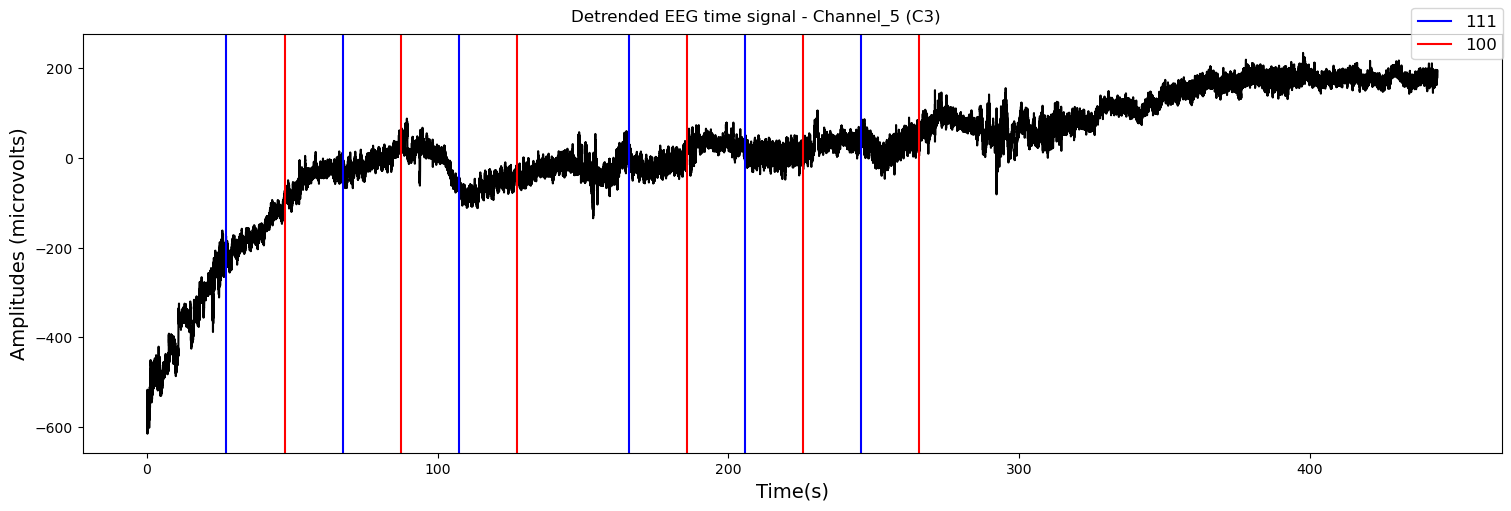

In [174]:
EEG_amplitudes_centered = detrend_signals(EEG_data["data"]["time_series"])

figure,axis=plt.subplots()
figure.suptitle(f"Detrended EEG time signal - {channel_num_name} ({channel_name})")
axis.plot(EEG_timestamps,EEG_amplitudes_centered[:,channel_index],color="black")
axis.set_xlabel("Time(s)")
axis.set_ylabel(f"Amplitudes ({EEG_units})")
show_markers2(plot_type=axis,markers_times_array=mouse_marker_times_labels)
figure.legend()


## Rereference EEG signals to average and show result on one signal

input_signals shape:(221938, 8)
input_signals whole mean:13.818697929382324
mean_vector shape: ()


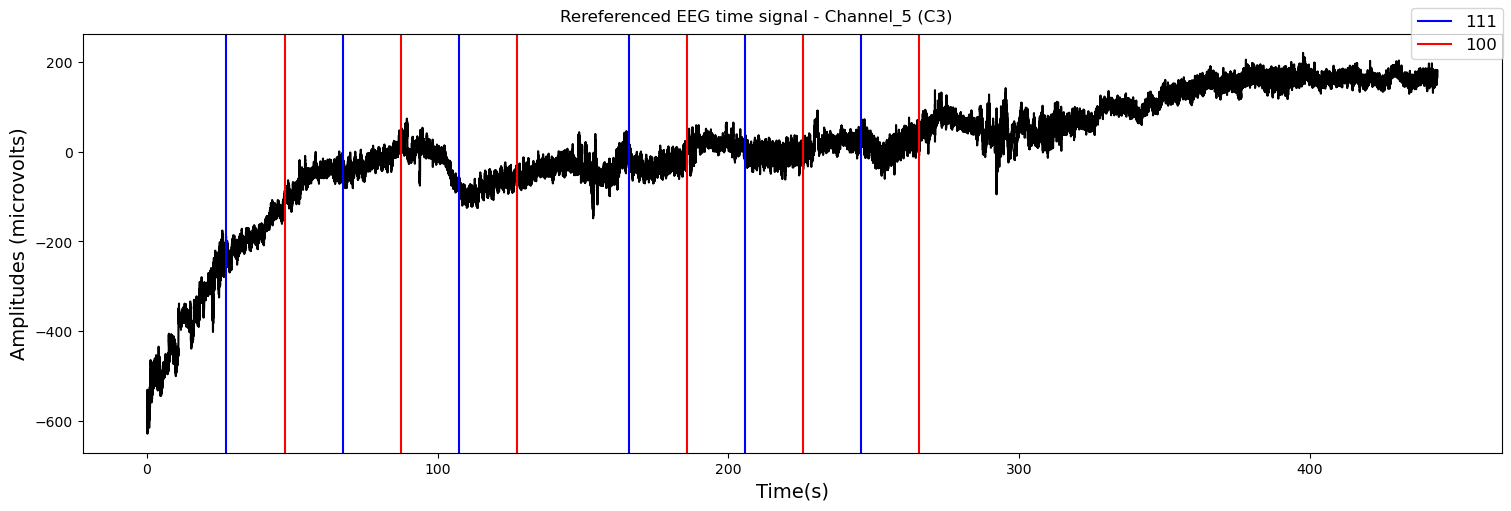

In [175]:
EEG_amplitudes_rereferenced = rereference_signals(input_signals=EEG_amplitudes_centered)

figure,axis=plt.subplots()
figure.suptitle(f"Rereferenced EEG time signal - {channel_num_name} ({channel_name})")
axis.plot(EEG_timestamps,EEG_amplitudes_rereferenced[:,channel_index],color="black")
axis.set_xlabel("Time(s)")
axis.set_ylabel(f"Amplitudes ({EEG_units})")
show_markers2(plot_type=axis,markers_times_array=mouse_marker_times_labels)
figure.legend()

## Filter EEG signals Notch (50Hz) and BP(3-100Hz) and show result on one signal

LOW_CUTOFF_FREQ_THEORETICAL=3,HIGH_CU-TOFF_FREQ_THEORETICAL=100
LOW_CUTOFF_FREQ_CORRECTED=2.839,HIGH_CUTOFF_FREQ_CORRECTED=104.203
NOTCH_CUTOFF_FREQ=50
Filtered signal shape: (221938, 8)


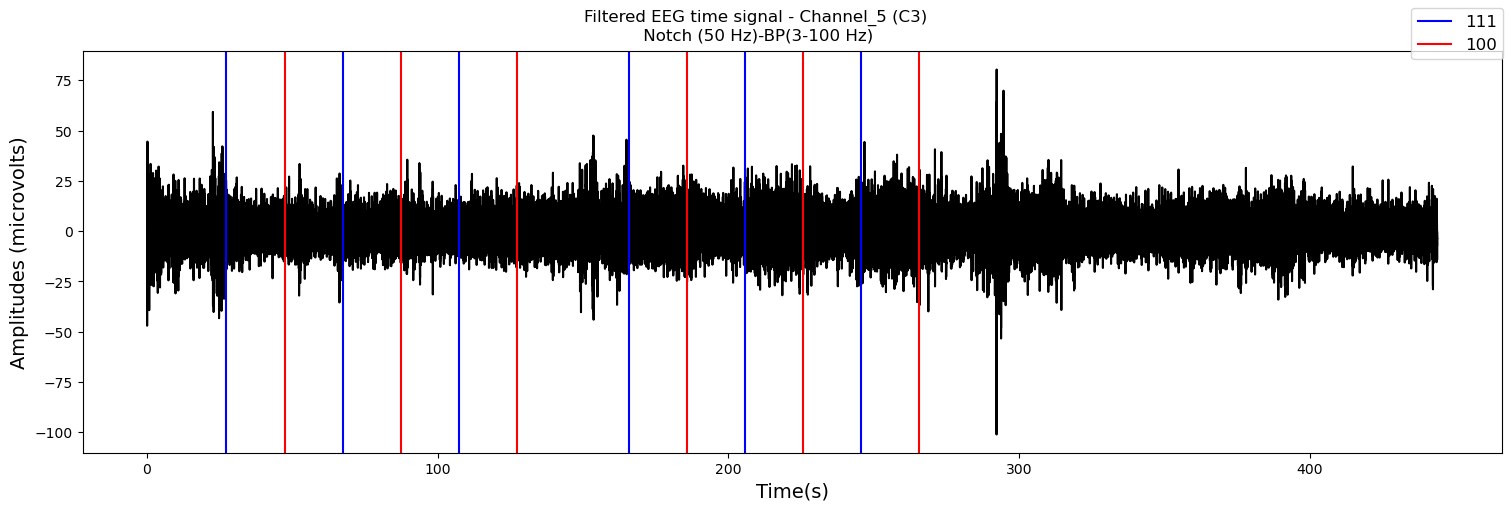

In [176]:
EEG_amplitudes_centered_filtered, filt_freqs, filt_response = filter_signal(input_signals=EEG_amplitudes_rereferenced, sample_rate=EEG_srate, order=8, cutofffreq=(3, 100, 50))

figure,axis=plt.subplots()
figure.suptitle(f"Filtered EEG time signal - {channel_num_name} ({channel_name})\n Notch (50 Hz)-BP(3-100 Hz)")
axis.plot(EEG_timestamps,EEG_amplitudes_centered_filtered[:,channel_index],color="black")
axis.set_xlabel("Time(s)")
axis.set_ylabel(f"Amplitudes ({EEG_units})")
show_markers2(plot_type=axis,markers_times_array=mouse_marker_times_labels)
figure.legend()

In [177]:
nearest_markers_array = nearest_timestamps_array_finder(signal_times_stamps=EEG_timestamps, markers=mouse_marker_times_labels)

MARKERS LEN: 12


## Compute ERSPs timecourse for all electrodes

In [178]:
epoch_param=(-6,6,1)
ersps_timecourses=time_frequency_ERSPs_all_signals(signals=EEG_amplitudes_centered_filtered,sample_rate=EEG_srate,
                                 markers_labels_times=nearest_markers_array,
                                 select_events=(111, 100),
                                 epoch_timecourse_limits=epoch_param)

(-6, -5)
221938
Epoch limits relative to events (in sec): start: -6s - end: -5s
Epoch limits relative to events (in samples): n_points_before_marker: -2999.9863622610987 - n_points_after_marker: -2499.988635217582
Event type : 111 ------------ epochs :
first_seg_coord: 10659 - second_seg_coord: 11159
first_seg_coord: 30660 - second_seg_coord: 31160
first_seg_coord: 50662 - second_seg_coord: 51162
first_seg_coord: 79834 - second_seg_coord: 80334
first_seg_coord: 99836 - second_seg_coord: 100336
first_seg_coord: 119837 - second_seg_coord: 120337
signal_segments shape: (501, 6)
time_segments shape: (501, 6)
Event type : 100 ------------ epochs :
first_seg_coord: 20660 - second_seg_coord: 21160
first_seg_coord: 40661 - second_seg_coord: 41161
first_seg_coord: 60663 - second_seg_coord: 61163
first_seg_coord: 89835 - second_seg_coord: 90335
first_seg_coord: 109837 - second_seg_coord: 110337
first_seg_coord: 129838 - second_seg_coord: 130338
signal_segments shape: (501, 6)
time_segments shape

## Plot ERSPs timecourse for one of all electrodes

In [179]:
ersps_timecourses_forplot_4darray,ersps_timecourses_forplot_list_3darrays=convert_time_frequency_ERSPs_all_signals(ERSP_timecourse_dict=ersps_timecourses)

In [180]:
print("ERSP timecourse 4d array",type(ersps_timecourses_forplot_4darray),ersps_timecourses_forplot_4darray.shape)
print("number of trials",len(ersps_timecourses_forplot_list_3darrays))
print("dimensions array3d",ersps_timecourses_forplot_list_3darrays[0].shape)

ERSP timecourse 4d array <class 'numpy.ndarray'> (13872, 12, 6, 8)
number of trials 8
dimensions array3d (13872, 12, 6)


In [181]:
frequencies=ersps_timecourses["(0, 1)"]["Channel_1"]["Epochs"]["ERSPs"]["ERSP_frequencies"]
print(frequencies[0])
print(frequencies[-1])

0.0
249.99886352175827


ersps_timecourses_forplot_list_3darrays shape (13872, 12, 6)
adaptable_colormap_range (0, 1665)
380.75635490055515
trial num 0


560.4708072100866
trial num 1
176.10798758485927
trial num 2
308.8989938625243
trial num 3
194.9971311822954
trial num 4
432.9926838353809
trial num 5


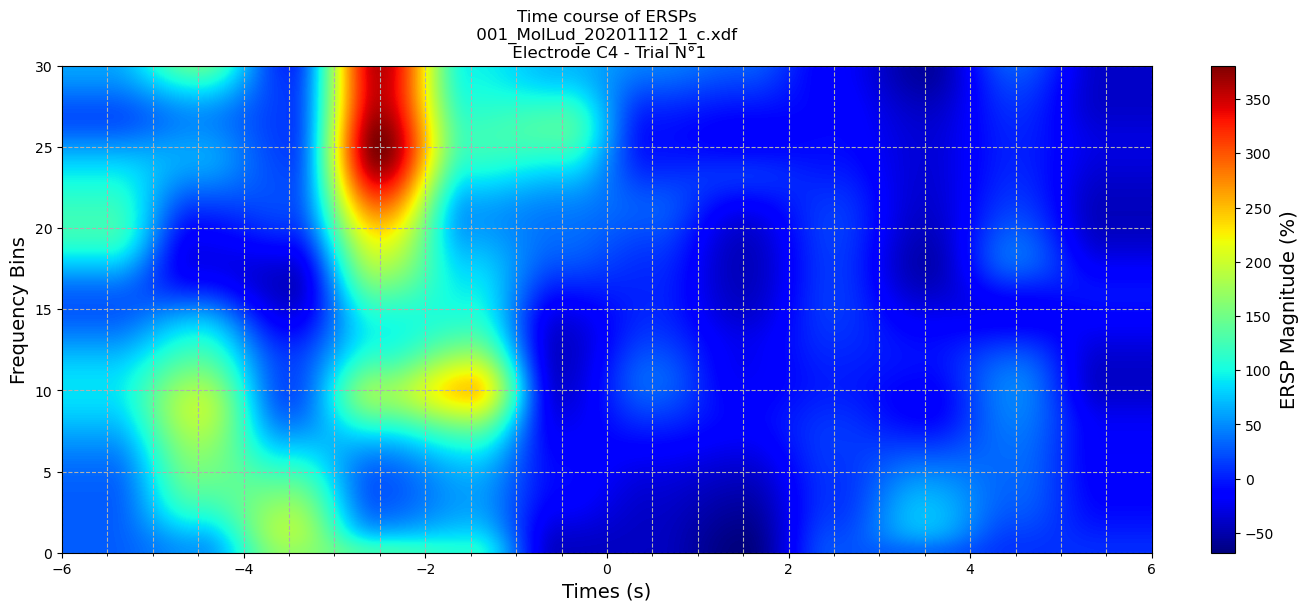

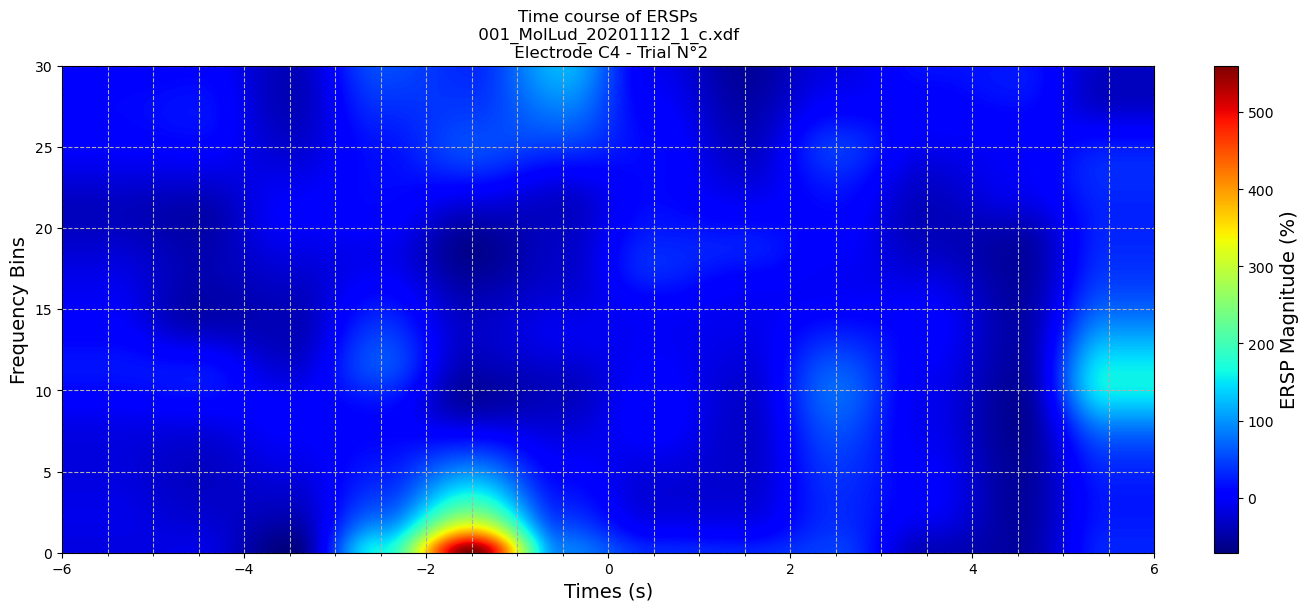

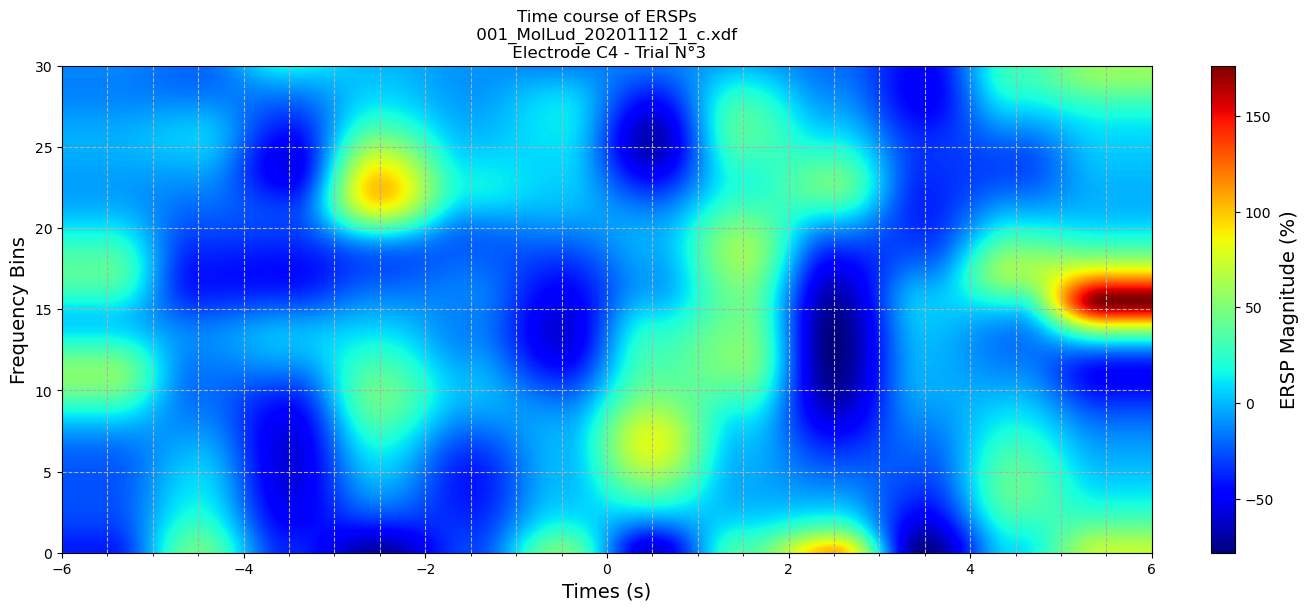

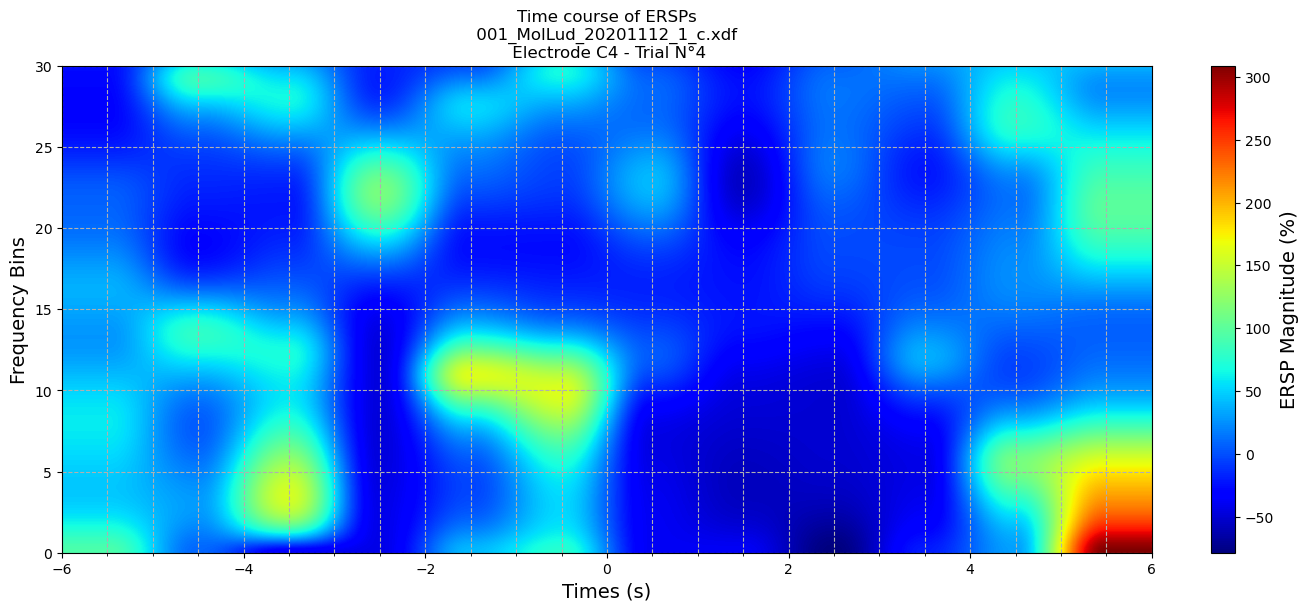

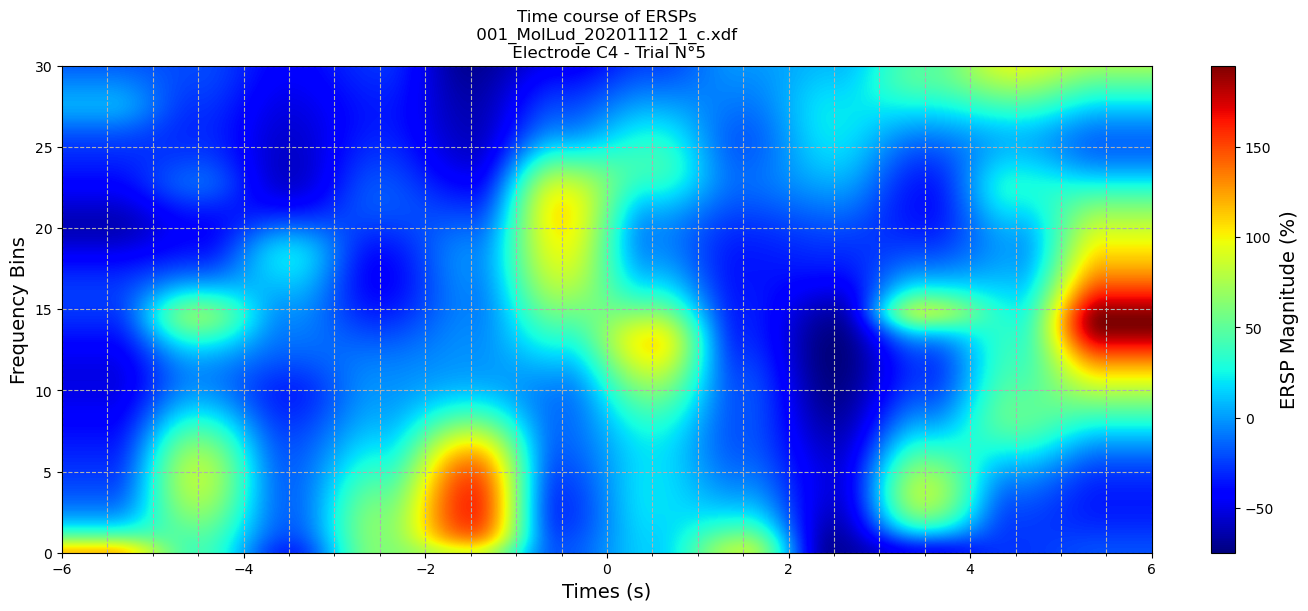

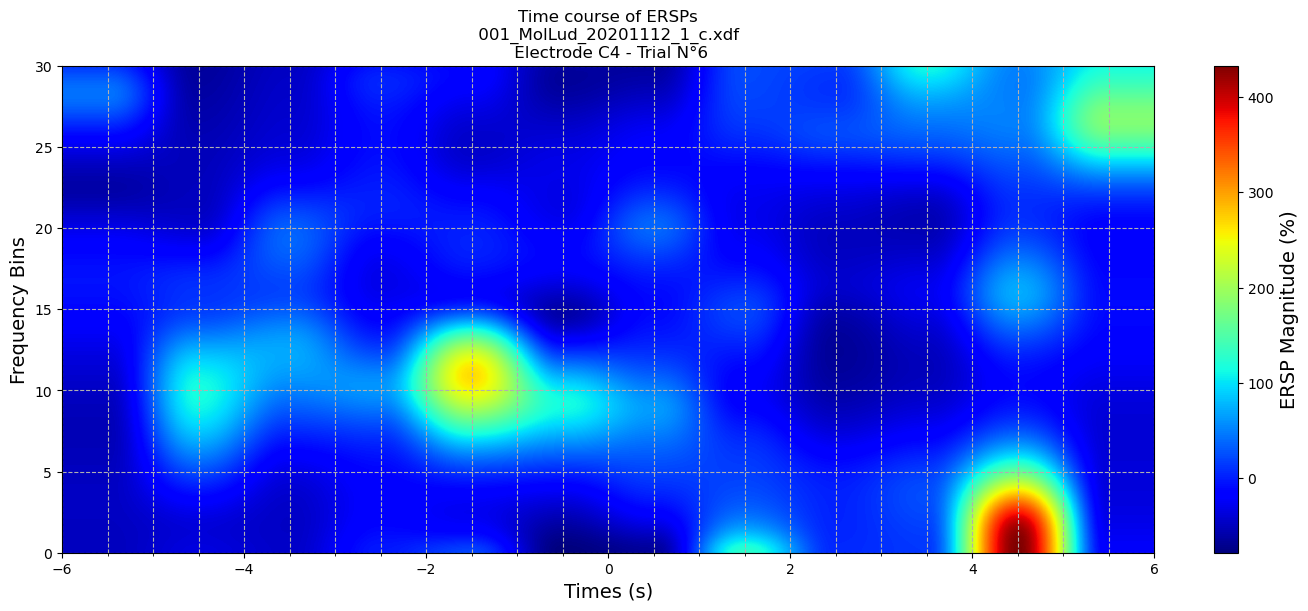

In [182]:
#V2
from matplotlib.ticker import AutoMinorLocator

channel_num=1
channel_index=channel_num-1
print("ersps_timecourses_forplot_list_3darrays shape",ersps_timecourses_forplot_list_3darrays[0].shape)
ylims=(0,30)
#print("frequencies shape",frequencies.shape)
#print("reso",frequencies[-1]/len(frequencies))
#print("frequencies[-1]",frequencies[-1])
#print("ook",round(30*len(frequencies)/frequencies[-1]))

adaptable_colormap_range=(ylims[0],round(ylims[1]*len(frequencies)/frequencies[-1]))
#print(frequencies[-1]/(frequencies[-1]/ylims[1]))
#print(channels_dict["Channel_"+str(channel_num)])
C4_ersp_timecourses_V1=[]
print("adaptable_colormap_range",adaptable_colormap_range)
for trial in range(ersps_timecourses_forplot_list_3darrays[0].shape[2]):
    data_ersp_timecourse=ersps_timecourses_forplot_list_3darrays[channel_index][:,:,trial]
    amplitude_range_data=data_ersp_timecourse[adaptable_colormap_range[0]:adaptable_colormap_range[-1],:]
    abs_amplitude_max=np.max(abs(amplitude_range_data))
    print(abs_amplitude_max)
    #print(data_ersp_timecourse.shape)
    #print(data_ersp_timecourse[adaptable_colormap_range[0]:adaptable_colormap_range[-1],:].shape)
    print("trial num",trial)
    # Create the time-frequency plot
    figure_ersp_i=plt.figure(figsize=(13, 6))

    # Use extent to specify the data limits for the axes
    plt.imshow(data_ersp_timecourse,extent=(epoch_param[0],epoch_param[1],frequencies[0],frequencies[-1]),vmin=np.min(amplitude_range_data),vmax=np.max(amplitude_range_data),
            aspect='auto', cmap='jet', origin='lower')
    plt.ylim(ylims)
    plt.xlim(epoch_param[0],epoch_param[1])

    ax = plt.gca()
    ax.xaxis.set_minor_locator(AutoMinorLocator())

    plt.grid(visible=True,which="both",axis="both",linestyle="dashed")
    plt.colorbar(label='ERSP Magnitude (%)')
    plt.title(f'Time course of ERSPs\n {xdf_input_filename} \n Electrode {channels_dict["Channel_"+str(channel_num)]} - Trial N°{trial+1}')
    plt.xlabel('Times (s)')
    plt.ylabel('Frequency Bins')
    C4_ersp_timecourses_V1.append(figure_ersp_i)

ersps_timecourses_forplot_list_3darrays shape (13872, 12, 6)
adaptable_colormap_range (0, 1665)
380.75635490055515
trial num 0
380.75635490055515 1121.0216501628906
560.4708072100866
trial num 1
560.4708072100866 560.4708072100866
176.10798758485927
trial num 2
176.10798758485927 200.83162653153855
308.8989938625243
trial num 3
308.8989938625243 308.8989938625243
194.9971311822954
trial num 4
194.9971311822954 301.80963203009065
432.9926838353809
trial num 5
432.9926838353809 432.9926838353809


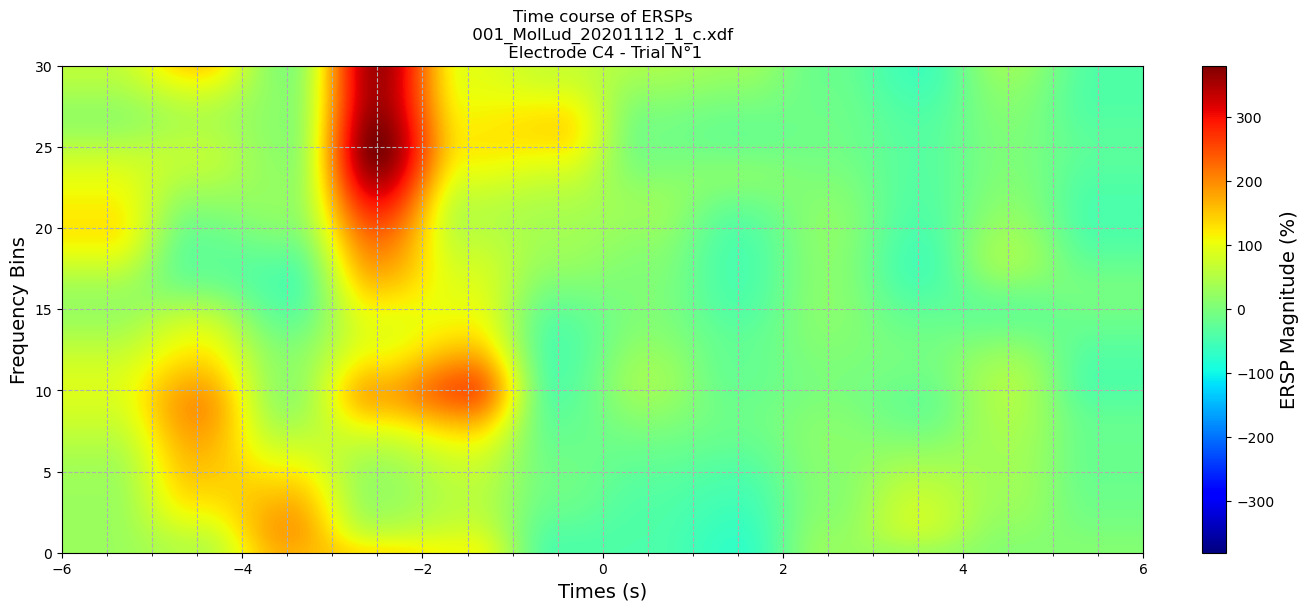

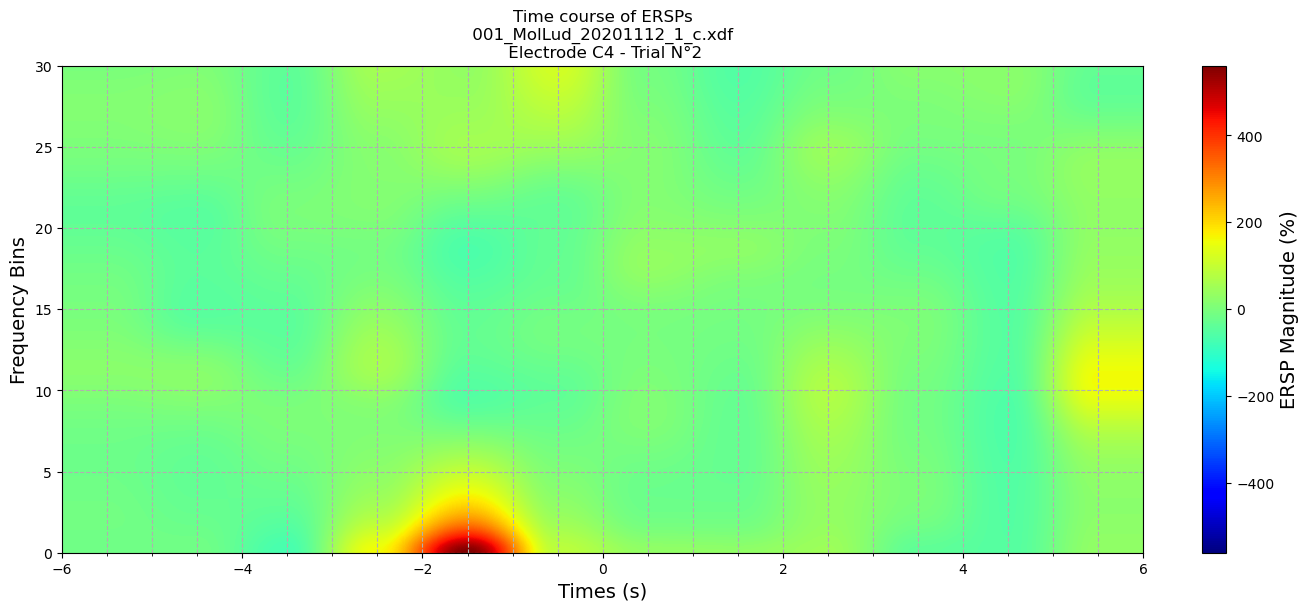

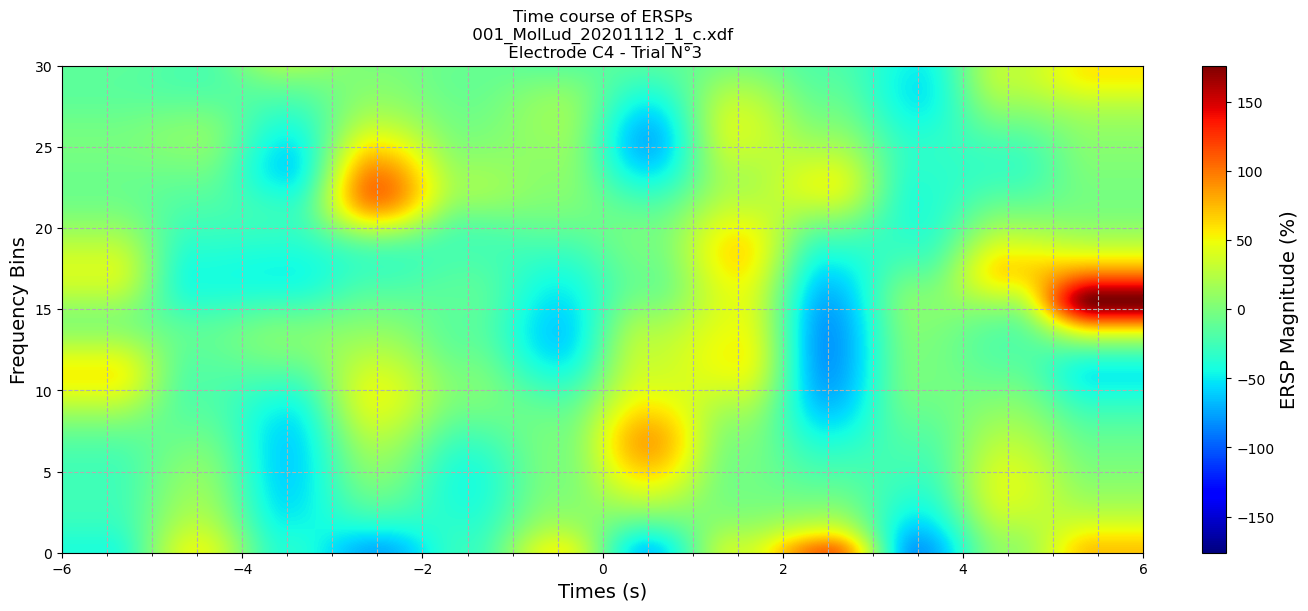

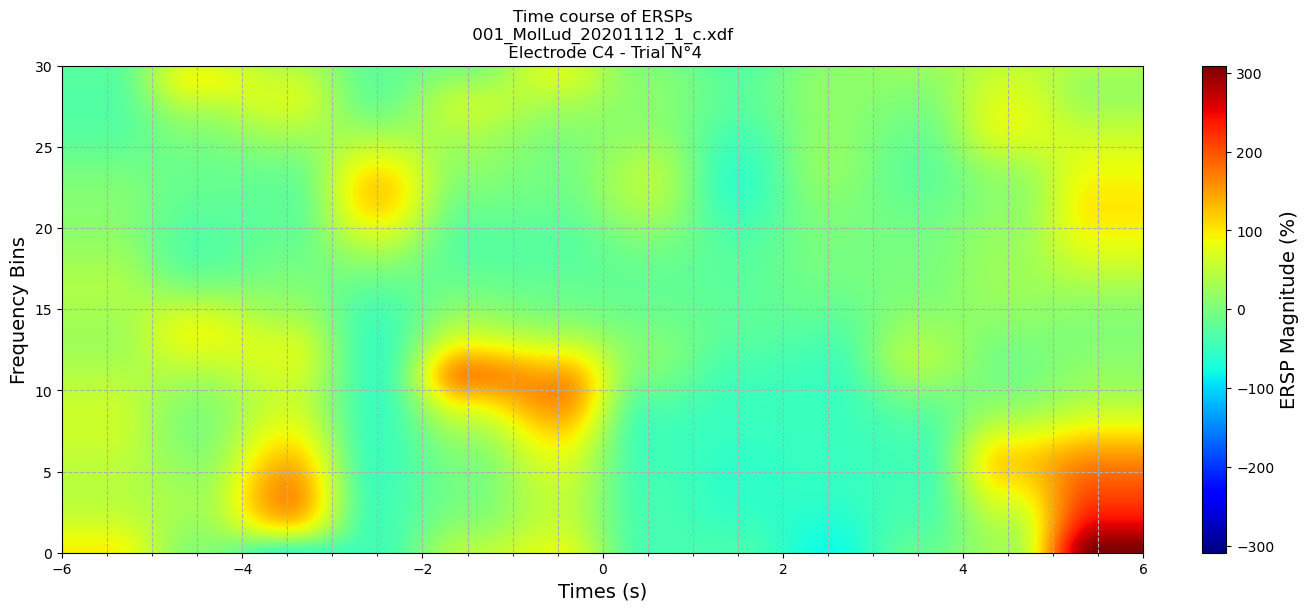

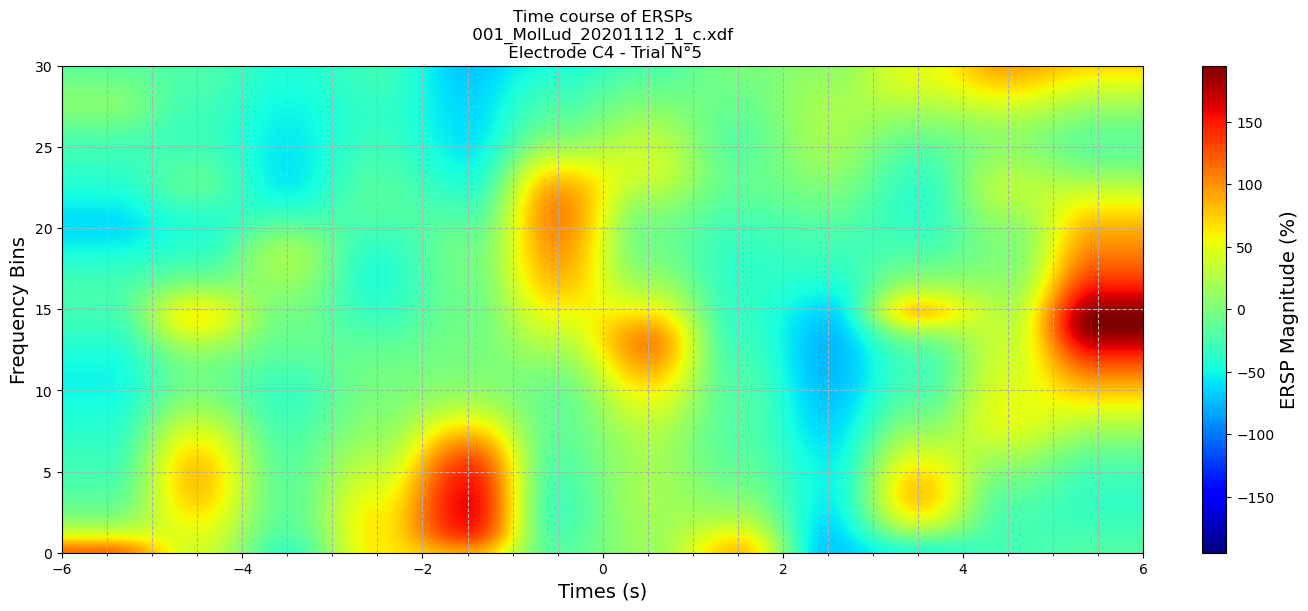

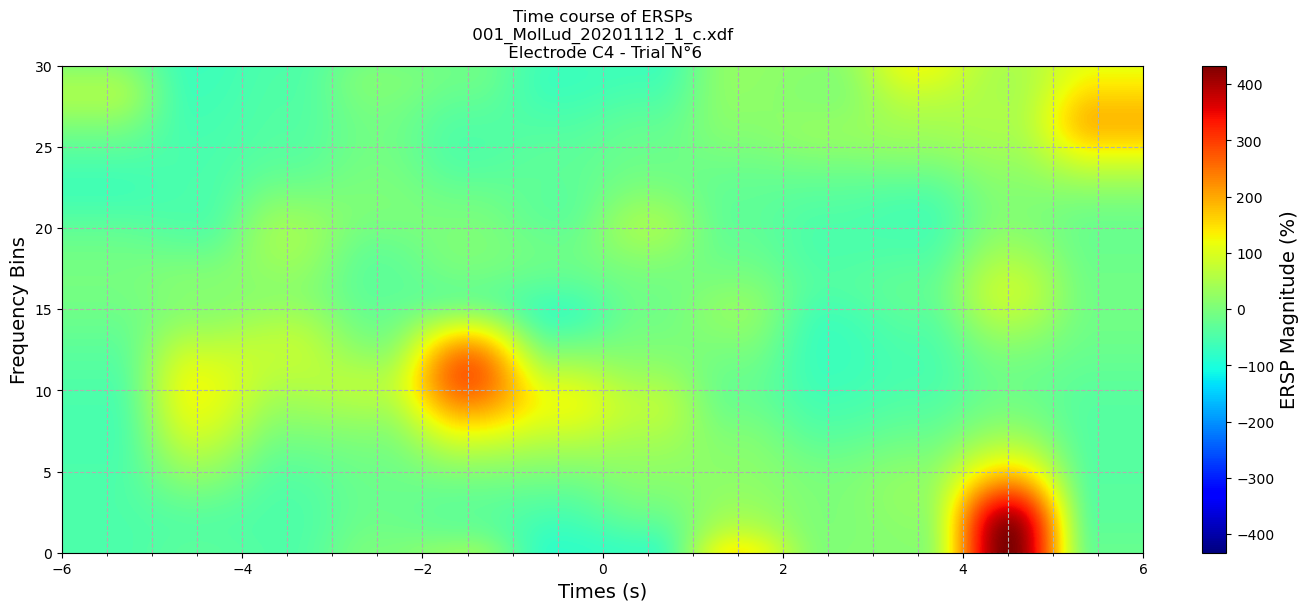

In [183]:
#V2
from matplotlib.ticker import AutoMinorLocator

channel_num=1
channel_index=channel_num-1
print("ersps_timecourses_forplot_list_3darrays shape",ersps_timecourses_forplot_list_3darrays[0].shape)
ylims=(0,30)
adaptable_colormap_range=(ylims[0],round(ylims[1]*len(frequencies)/frequencies[-1]))
print("adaptable_colormap_range",adaptable_colormap_range)

C4_ersp_timecourses_V2=[]
for trial in range(ersps_timecourses_forplot_list_3darrays[0].shape[2]):
    data_ersp_timecourse=ersps_timecourses_forplot_list_3darrays[channel_index][:,:,trial]
    amplitude_range_data=data_ersp_timecourse[adaptable_colormap_range[0]:adaptable_colormap_range[-1],:]
    abs_amplitude_max=np.max(abs(amplitude_range_data))
    print(abs_amplitude_max)
    print("trial num",trial)
    print(abs_amplitude_max,np.max(data_ersp_timecourse))

    figure_ersp_i=plt.figure(figsize=(13, 6))

    # Use extent to specify the data limits for the axes
    plt.imshow(data_ersp_timecourse,extent=(epoch_param[0],epoch_param[1],frequencies[0],frequencies[-1]),vmin=-abs_amplitude_max,vmax=abs_amplitude_max,
            aspect='auto', cmap='jet', origin='lower')
    plt.ylim(ylims)
    plt.xlim(epoch_param[0],epoch_param[1])

    ax = plt.gca()
    ax.xaxis.set_minor_locator(AutoMinorLocator())

    plt.grid(visible=True,which="both",axis="both",linestyle="dashed")
    plt.colorbar(label='ERSP Magnitude (%)')
    plt.title(f'Time course of ERSPs\n {xdf_input_filename} \n Electrode {channels_dict["Channel_"+str(channel_num)]} - Trial N°{trial+1}')
    plt.xlabel('Times (s)')
    plt.ylabel('Frequency Bins')
    C4_ersp_timecourses_V2.append(figure_ersp_i)

ersps_timecourses_forplot_list_3darrays shape (13872, 12, 6)
adaptable_colormap_range (0, 1665)
340.3319546306066
trial num 0
612.0327382784324
trial num 1
289.60111621102124
trial num 2
249.7903128763075
trial num 3
160.53497671203948
trial num 4
211.24809331231367
trial num 5


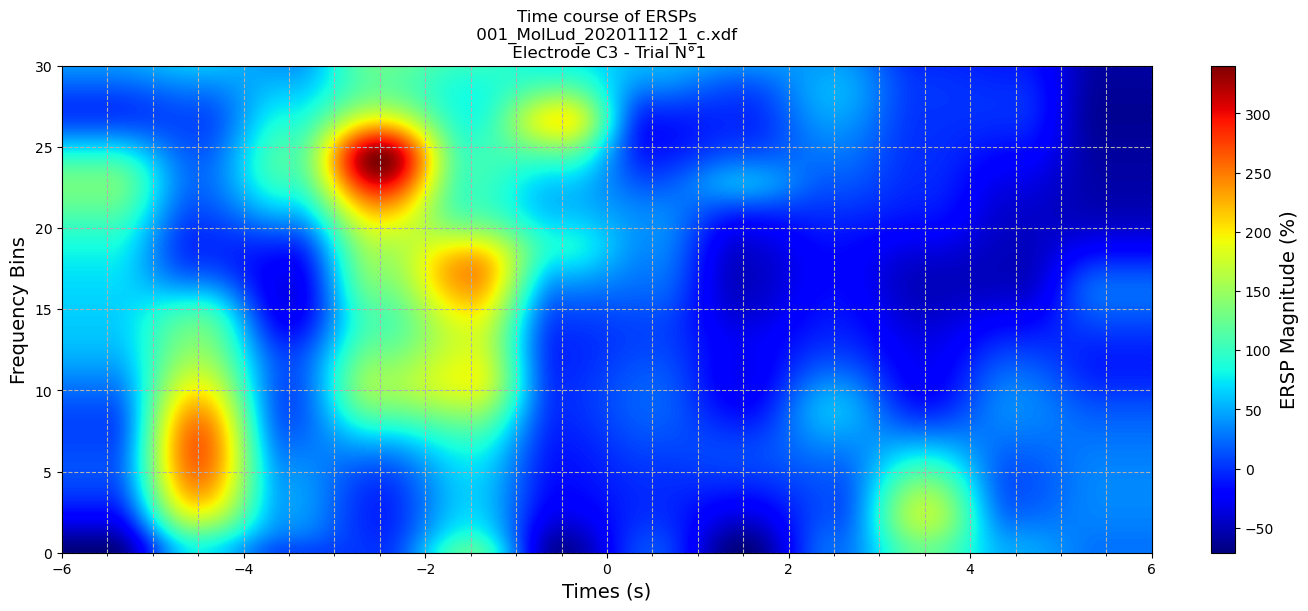

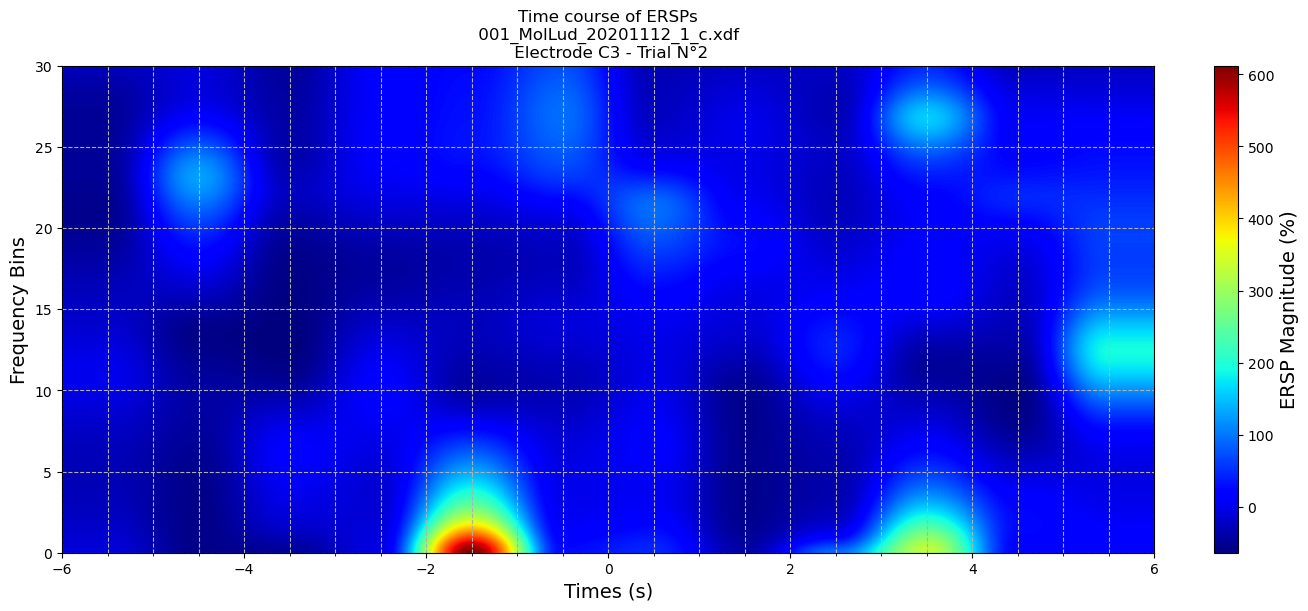

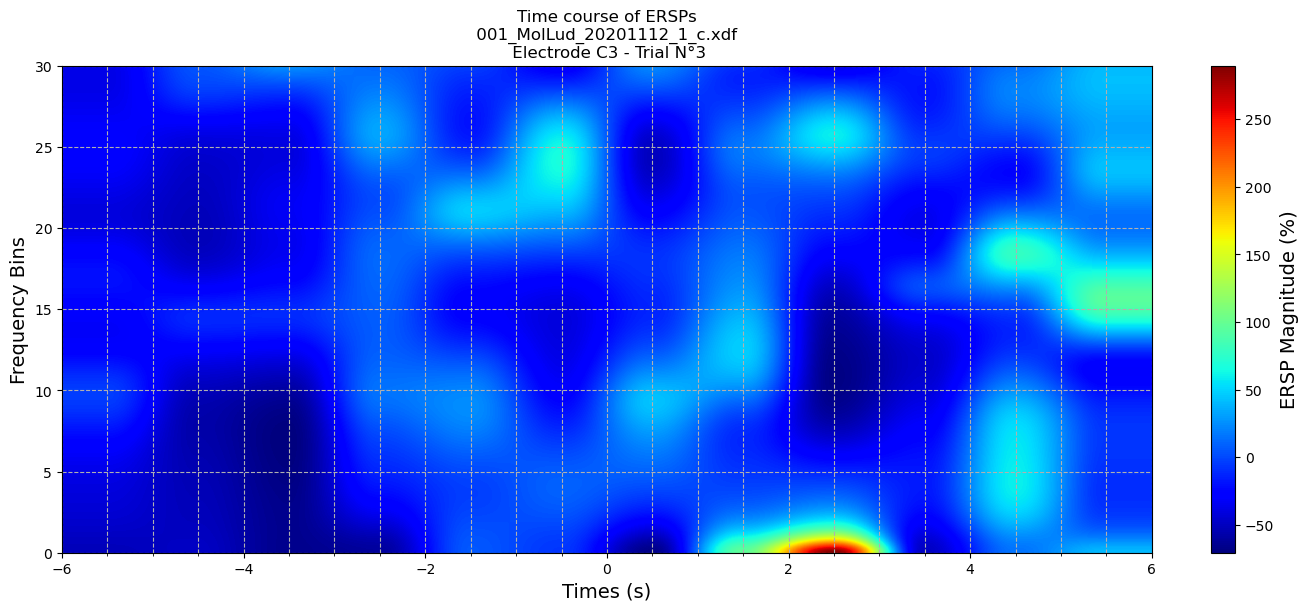

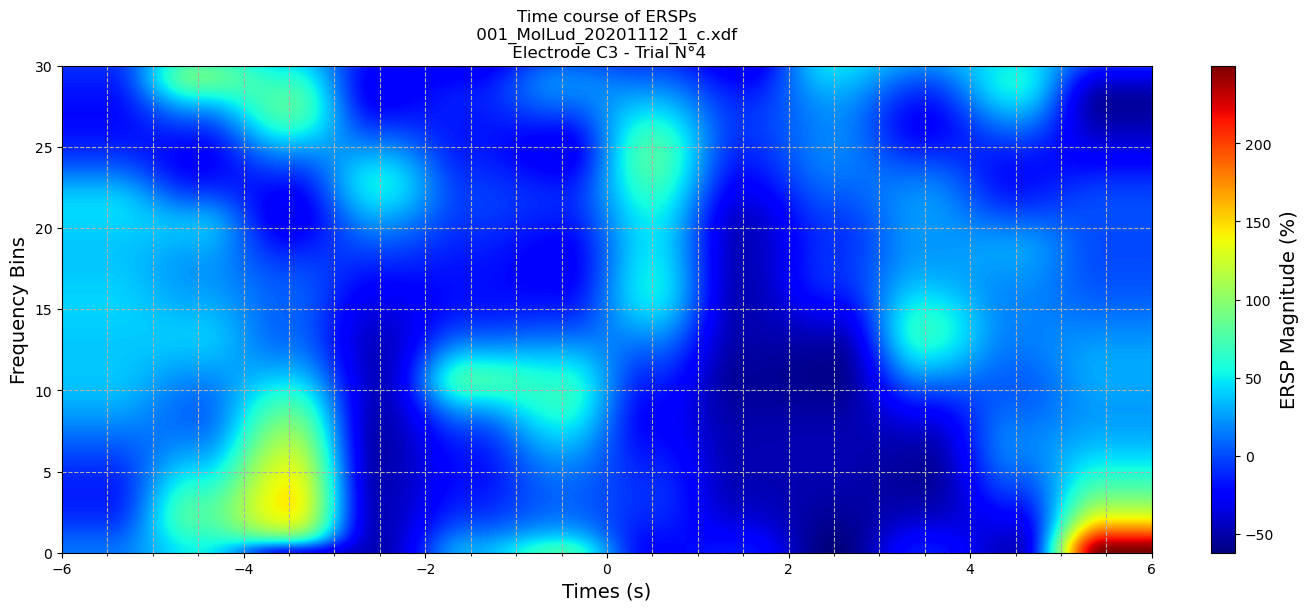

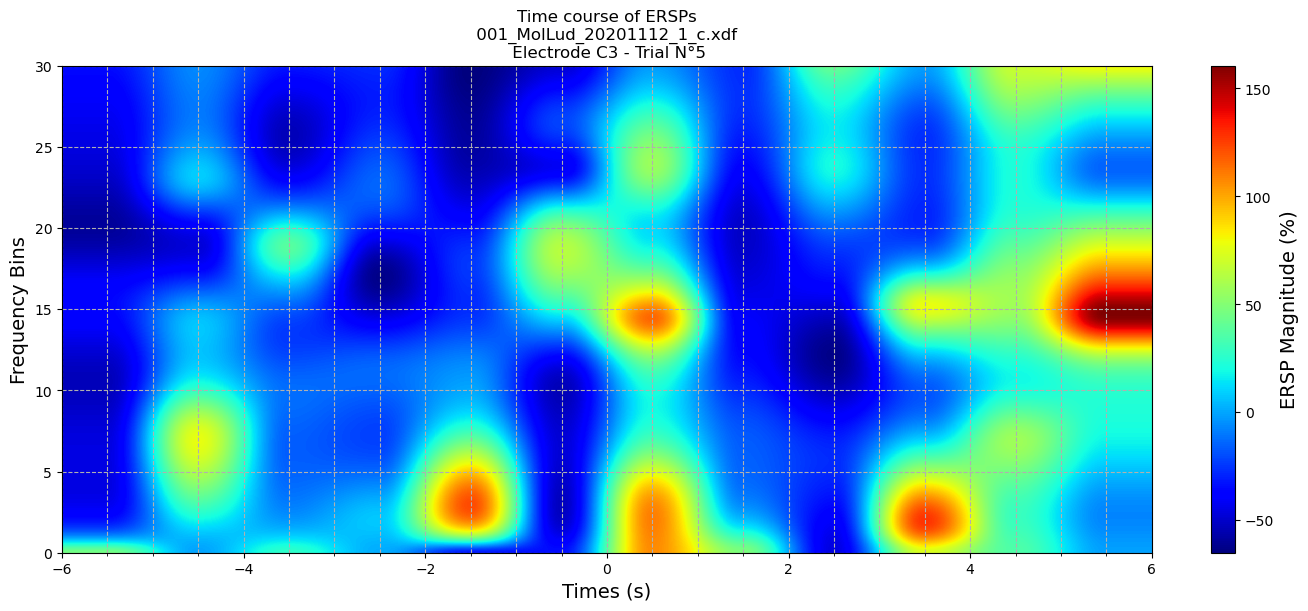

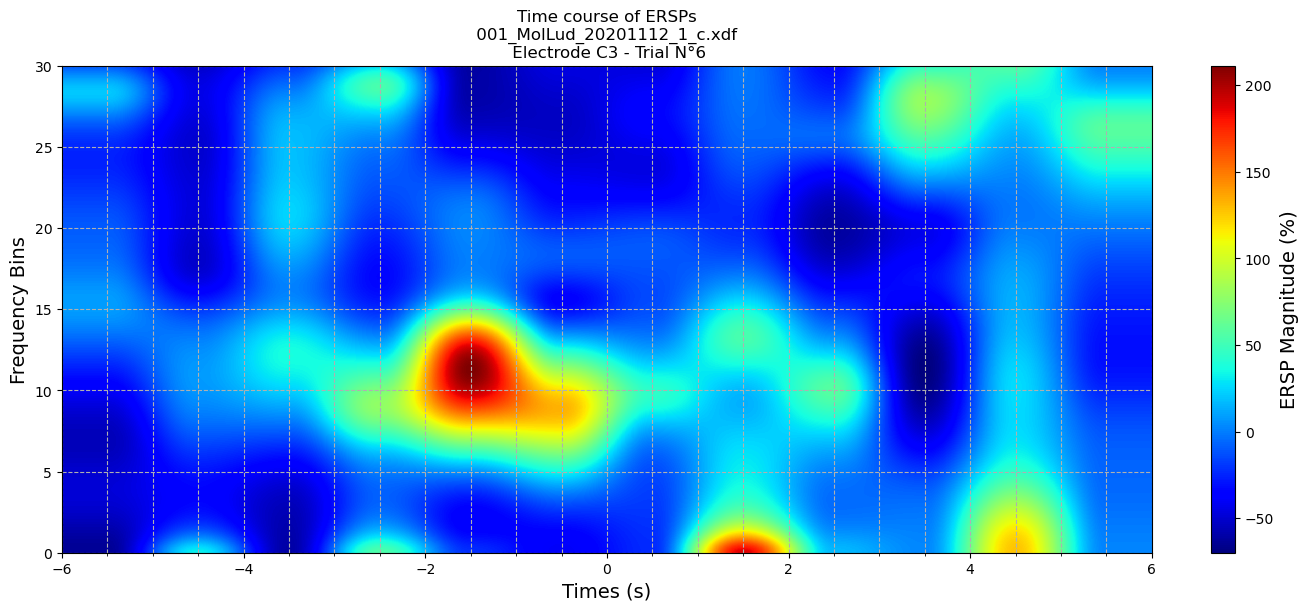

In [184]:
#V2
from matplotlib.ticker import AutoMinorLocator

channel_num=5
channel_index=channel_num-1
print("ersps_timecourses_forplot_list_3darrays shape",ersps_timecourses_forplot_list_3darrays[0].shape)
ylims=(0,30)
#print("frequencies shape",frequencies.shape)
#print("reso",frequencies[-1]/len(frequencies))
#print("frequencies[-1]",frequencies[-1])
#print("ook",round(30*len(frequencies)/frequencies[-1]))

adaptable_colormap_range=(ylims[0],round(ylims[1]*len(frequencies)/frequencies[-1]))
#print(frequencies[-1]/(frequencies[-1]/ylims[1]))
#print(channels_dict["Channel_"+str(channel_num)])

print("adaptable_colormap_range",adaptable_colormap_range)
C3_ersp_timecourses_V1=[]
for trial in range(ersps_timecourses_forplot_list_3darrays[0].shape[2]):
    data_ersp_timecourse=ersps_timecourses_forplot_list_3darrays[channel_index][:,:,trial]
    amplitude_range_data=data_ersp_timecourse[adaptable_colormap_range[0]:adaptable_colormap_range[-1],:]
    abs_amplitude_max=np.max(abs(amplitude_range_data))
    print(abs_amplitude_max)
    #print(data_ersp_timecourse.shape)
    #print(data_ersp_timecourse[adaptable_colormap_range[0]:adaptable_colormap_range[-1],:].shape)
    print("trial num",trial)
    # Create the time-frequency plot
    figure_ersp_i=plt.figure(figsize=(13, 6))

    # Use extent to specify the data limits for the axes
    plt.imshow(data_ersp_timecourse,extent=(epoch_param[0],epoch_param[1],frequencies[0],frequencies[-1]),vmin=np.min(amplitude_range_data),vmax=np.max(amplitude_range_data),
            aspect='auto', cmap='jet', origin='lower')
    plt.ylim(ylims)
    plt.xlim(epoch_param[0],epoch_param[1])

    ax = plt.gca()
    ax.xaxis.set_minor_locator(AutoMinorLocator())

    plt.grid(visible=True,which="both",axis="both",linestyle="dashed")
    plt.colorbar(label='ERSP Magnitude (%)')
    plt.title(f'Time course of ERSPs\n {xdf_input_filename} \n Electrode {channels_dict["Channel_"+str(channel_num)]} - Trial N°{trial+1}')
    plt.xlabel('Times (s)')
    plt.ylabel('Frequency Bins')
    C3_ersp_timecourses_V1.append(figure_ersp_i)

ersps_timecourses_forplot_list_3darrays shape (13872, 12, 6)
adaptable_colormap_range (0, 1665)
340.3319546306066
trial num 0
340.3319546306066 630.2283137517587
612.0327382784324
trial num 1
612.0327382784324 612.0327382784324
289.60111621102124
trial num 2
289.60111621102124 289.60111621102124
249.7903128763075
trial num 3
249.7903128763075 249.7903128763075
160.53497671203948
trial num 4
160.53497671203948 197.77342267318457
211.24809331231367
trial num 5
211.24809331231367 269.5610131842284
C3_ersp_timecourses_V2 len: 6


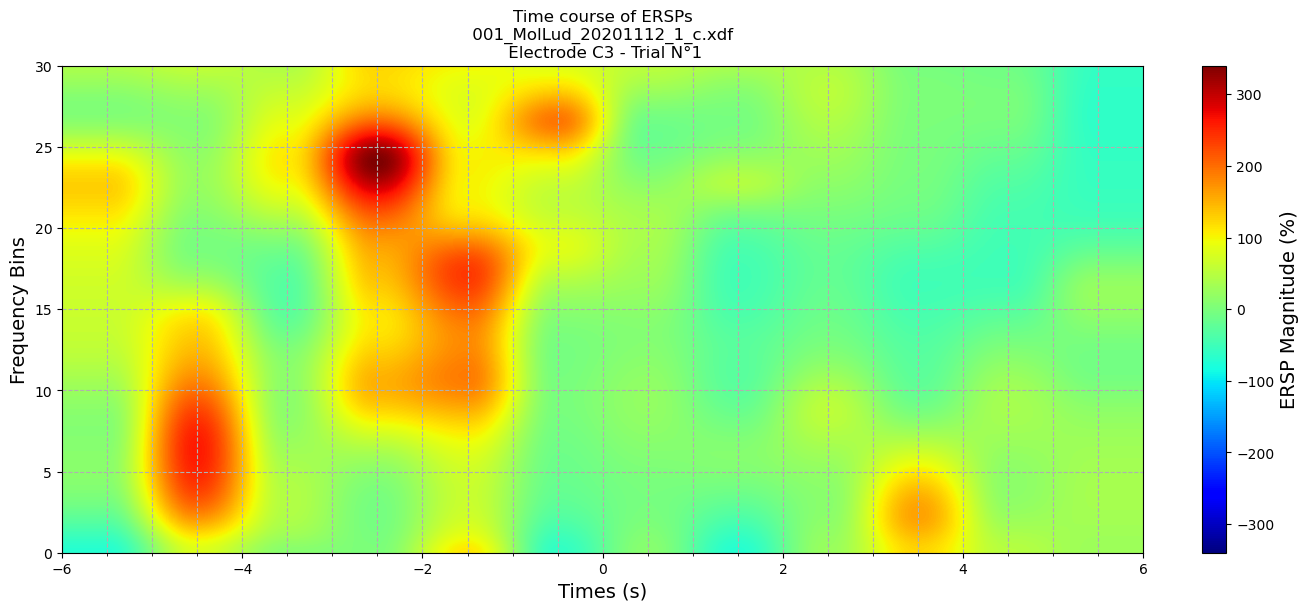

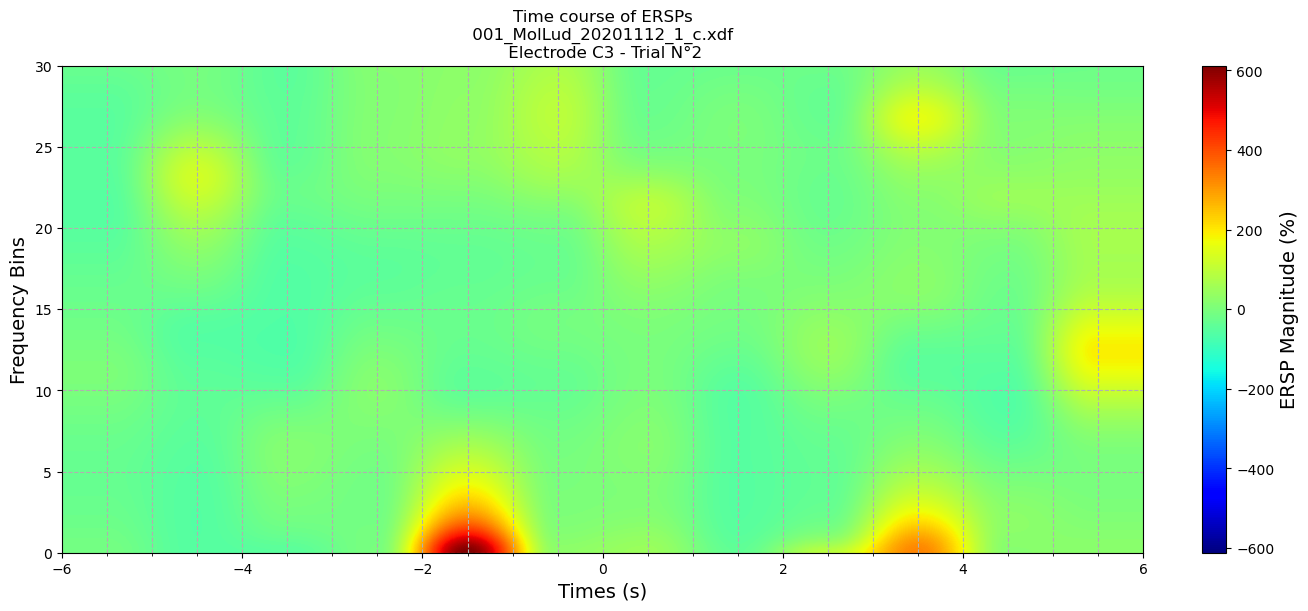

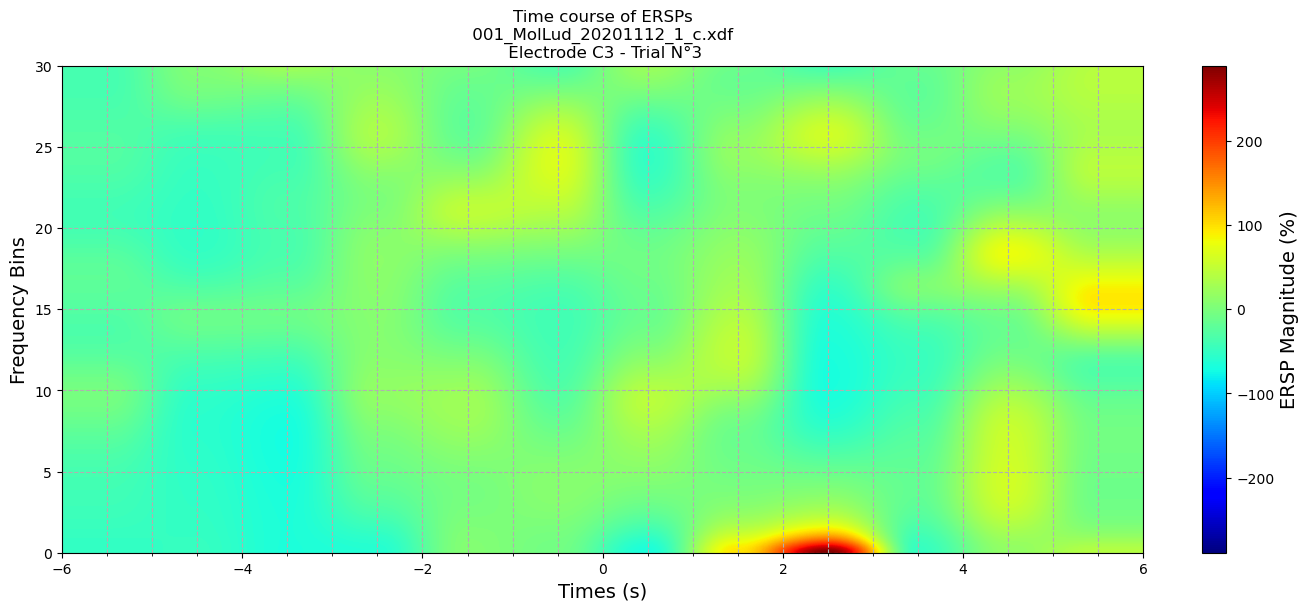

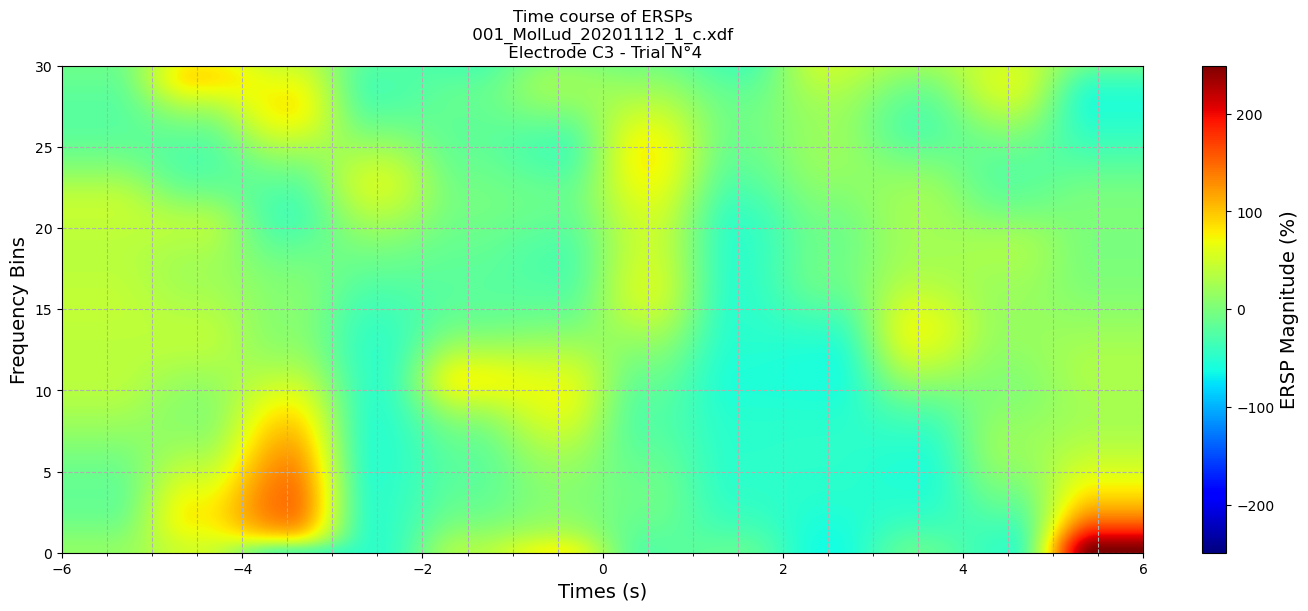

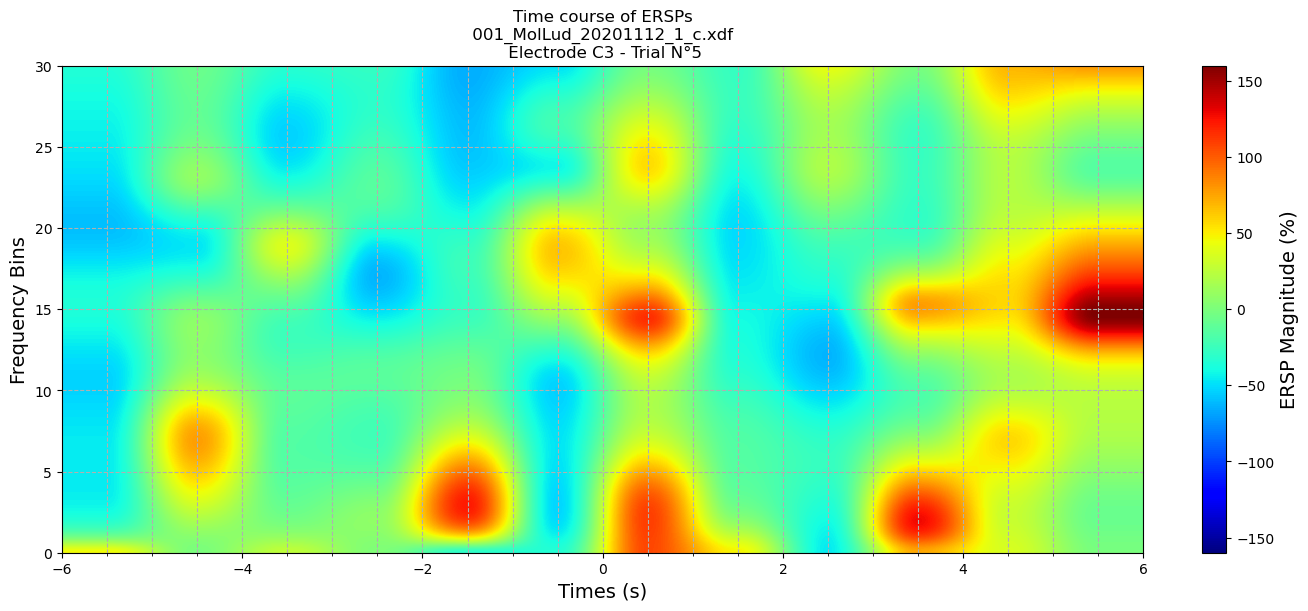

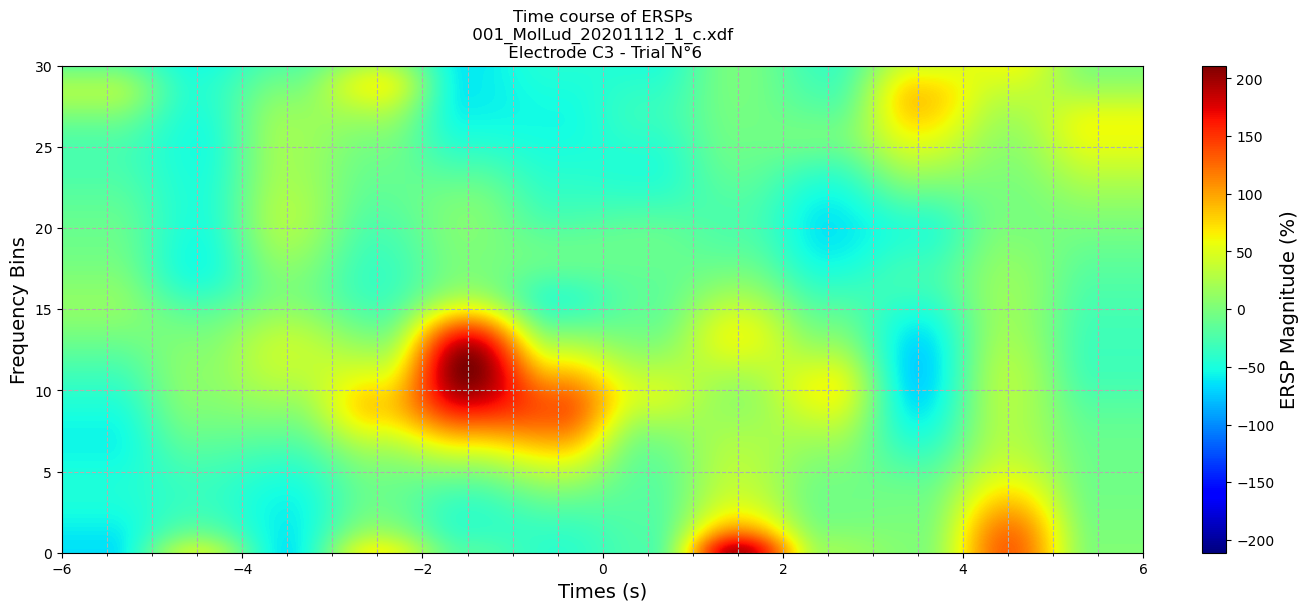

In [185]:
#V2
from matplotlib.ticker import AutoMinorLocator

channel_num=5
channel_index=channel_num-1
print("ersps_timecourses_forplot_list_3darrays shape",ersps_timecourses_forplot_list_3darrays[0].shape)
ylims=(0,30)
adaptable_colormap_range=(ylims[0],round(ylims[1]*len(frequencies)/frequencies[-1]))
C3_ersp_timecourses_V2=[]

print("adaptable_colormap_range",adaptable_colormap_range)
for trial in range(ersps_timecourses_forplot_list_3darrays[0].shape[2]):
    data_ersp_timecourse=ersps_timecourses_forplot_list_3darrays[channel_index][:,:,trial]
    amplitude_range_data=data_ersp_timecourse[adaptable_colormap_range[0]:adaptable_colormap_range[-1],:]
    abs_amplitude_max=np.max(abs(amplitude_range_data))
    print(abs_amplitude_max)
    print("trial num",trial)
    print(abs_amplitude_max,np.max(data_ersp_timecourse))

    figure_ersp_i=plt.figure(figsize=(13, 6))

    # Use extent to specify the data limits for the axes
    plt.imshow(data_ersp_timecourse,extent=(epoch_param[0],epoch_param[1],frequencies[0],frequencies[-1]),vmin=-1*int(abs_amplitude_max),vmax=int(abs_amplitude_max),
            aspect='auto', cmap='jet', origin='lower')
    plt.ylim(ylims)
    plt.xlim(epoch_param[0],epoch_param[1])

    ax = plt.gca()
    ax.xaxis.set_minor_locator(AutoMinorLocator())

    plt.grid(visible=True,which="both",axis="both",linestyle="dashed")
    plt.colorbar(label='ERSP Magnitude (%)')
    plt.title(f'Time course of ERSPs\n {xdf_input_filename} \n Electrode {channels_dict["Channel_"+str(channel_num)]} - Trial N°{trial+1}')
    plt.xlabel('Times (s)')
    plt.ylabel('Frequency Bins')
    C3_ersp_timecourses_V2.append(figure_ersp_i)
print("C3_ersp_timecourses_V2 len:",len(C3_ersp_timecourses_V2))


In [187]:
ersp_timecourses_figures_list=["C3_ersp_timecourses_V1","C3_ersp_timecourses_V2","C4_ersp_timecourses_V1","C4_ersp_timecourses_V2"]
for ersp_timecourse in ersp_timecourses_figures_list:
    print(ersp_timecourse)
    #print(type(globals()[ersp_timecourse]))
    save_figures_to_pdf_single_per_page(pdf_filename=f"DAT/OUTPUT/Figures/ERSPs/{ersp_timecourse}.pdf", figures_list=globals()[ersp_timecourse])
